In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import random as rm
import numpy as np
from numpy.random import default_rng

rng = default_rng()

In [2]:
def str2int_arr(str):
    return np.array([float(i) for i in str], dtype="byte")

def graph_from_file(file):
    w = []
    with open(file, "r") as f:
        for line in f:
            arr = line.split()
            map(int, arr)
            w.append(str2int_arr(arr))
    return nx.from_numpy_matrix(np.array(w))

def graph_from_dimacs(file):
    G = nx.Graph()
    with open(file, "r") as f:
        for line in f:
            buff = line.split()
            if buff[0]=="p":
                G.add_nodes_from([i for i in range(1, int(buff[2])+1 )])
                break
        for line in f:
            edge = line.split()
            G.add_edge(int(edge[1]), int(edge[2]))
    return G

In [3]:
def f_activations(x):
    return 1 / ( 1 + np.exp(x) )

def f_act01(x):
    return 1 if x > 0 else 0

def energy(X, W, B=1):
    n = len(X)
    sum = 0
    for i in range(n):
        for j in range(i, n):
            sum += W[i, j]*X[i]*X[j]
    
    n = np.sum(X)
    return n + (-n*(n-1)//2 + sum)*2*B, n, -n*(n-1)//2, sum#(-n*(n-1)//2 + sum//2) * B + n
    
def multy_mutation(individual):
    n = individual.size
    num_mutation=n//3
    
    for _ in range(num_mutation):
        individual[np.random.randint(0, n)] ^= 1
    return individual

def NN(W, X ,B=0.5, times=1000, mnitc=1000):
    N = X.size
    h_i = 1
    energies = np.array([], dtype="int")
    xs = []
    
    iter_no_change = np.intc(0)

    for _ in range(times):
        
        i = rng.integers(N)  # num_update
        X_next = 0
        
        for j in range(N):
            X_next += (1-W[i, j])*X[j]
        X_next = f_act01(X_next*(-B) + h_i)
        
        # X_next = f_act01(np.dot(W[i][:], X) - h_i)
        
        
        if X[i] == X_next:
            iter_no_change += 1
        else:
            iter_no_change = np.intc(0)
            X[i] = X_next
            energies = np.append(energies, energy(X, W, B)[0])
            xs.append(X.copy())
            # print(X)
            
        if( iter_no_change>=mnitc): 
            break
        
    return X, energies, xs

## Загрузка графа

In [5]:
#G = graph_from_file("graph_examples/34_14")
G = graph_from_dimacs("data/DIMACS_subset_ascii/C500.9.clq")
W = nx.adjacency_matrix(G).todense()
# nx.draw(G, with_labels=True)

C:\Users\arkad\AppData\Local\Temp\ipykernel_8656\3291982825.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


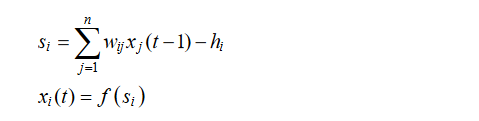

In [7]:
import pickle
with open('data/graphFromGaToHop/data500.pkl', 'rb') as input:
    pop_ga = pickle.load(input)

In [8]:
len(pop_ga)

40

In [10]:
#X = np.ones(G.number_of_nodes(), dtype="byte")
out_energ = []
for x in pop_ga:
    X = x
    X, energies, xs = NN(W, X, 0.6, 200)#00)
    out_energ.append(max(energies))

print(out_energ, sep="\n")
#X

[30.200000000000003, -19.199999999999996, -5.399999999999999, -11.0, -39.599999999999994, -17.799999999999997, -60.8, -36.599999999999994, -25.599999999999994, -50.2, -36.8, -18.4, -39.599999999999994, -9.799999999999997, -32.0, -37.2, -25.0, -28.200000000000003, -26.799999999999997, -37.8, -8.199999999999996, -17.4, -38.39999999999999, -16.0, -9.799999999999997, -32.8, -13.799999999999997, -15.199999999999996, -28.799999999999997, -6.600000000000001, -32.599999999999994, -26.200000000000003, -20.0, -52.599999999999994, -13.199999999999996, -25.0, -16.599999999999994, -15.399999999999999, -11.199999999999996, -7.799999999999997]


In [58]:
out_energ = []
for x in pop_ga:
    X = x
    X, energies, xs = NN(W, X, 0.6, 15000)
    out_energ.append(max(energies))

print(out_energ, sep="\n")

[50.0, 52.0, 50.0, 47.0, 48.0, 50.0, 48.0, 47.8, 49.6, 48.8, 48.0, 49.0, 53.0, 51.0, 48.0, 53.0, 51.0, 49.0, 47.0, 48.0, 49.0, 49.0, 52.0, 47.0, 48.0, 50.0, 48.0, 50.0, 50.0, 47.8, 50.0, 48.0, 49.0, 48.8, 47.0, 47.8, 49.0, 50.0, 47.8, 49.0]


In [51]:
X = np.ones(G.number_of_nodes(), dtype="byte")
X = pop_ga[0]

X, energies, xs = NN(W, X, 0.6, 20000)

    
print(energies, sep="\n")

[34.8 35.  34.8 34.6 34.4 34.6 34.8 35.8 37.2 37.  36.8 36.6 36.8 36.6
 36.8 37.  38.  38.2 38.4 38.2 38.4 38.6 38.4 38.2 38.  37.8 38.  38.2
 38.  37.8 38.  37.8 38.8 39.  39.2 39.  38.8 39.  38.8 38.6 38.8 38.6
 40.  40.2 40.  39.8 40.  40.2 40.  40.2 40.  39.8 39.6 39.8 40.  39.8
 40.  39.8 40.  39.8 40.  39.8 39.6 39.8 39.6 41.  42.  41.8 42.  41.8
 41.6 41.8 42.  41.8 41.6 41.8 42.  43.4 44.4 44.6 45.6 45.8 45.6 45.4
 45.2 45.4 45.6 45.8 46.8 46.6 46.8 46.6 46.4 46.6 46.4 47.4 47.2 47.4
 47.6 47.4 47.6 47.8 47.6 47.8 47.6 47.4 47.6 47.4 47.6 47.4 47.6 47.8
 47.6 47.4 47.6 47.4 47.6 47.4 47.6 47.4 47.2 47.4 47.2 47.4 47.6 47.8
 47.6 47.4 47.2 47.4 47.6 47.4 47.2 47.  47.2 47.4 47.2 47.  47.2 47.
 47.2 47.4 47.6 47.4 47.2 47.  47.2 47.4 47.6 47.4 47.6 47.4 47.6 47.4
 48.4 48.6 48.8 49.  48.8 48.6 48.4 48.6 48.4 48.6 48.4 48.6 48.8 48.6
 48.8 49.  48.8 48.6 48.8 49.  48.8 48.6 48.4 48.6 48.8 48.6 48.4 48.2
 48.4 48.2 48.4 48.6 48.4 48.6 48.4 48.6 48.4 48.6 48.4 48.2 48.4 48.2
 48.4 4

In [43]:
energies[-1]

33.0

In [63]:
hi = np.linspace(0.2, 2.0, 15)
energies_ = []

for i in hi:
    _, a, _ =  NN(W, np.ones(G.number_of_nodes(), dtype="byte") ,B=i, times=10000)
    energies_.append(a[-1])
    


Xi = []
#Xi

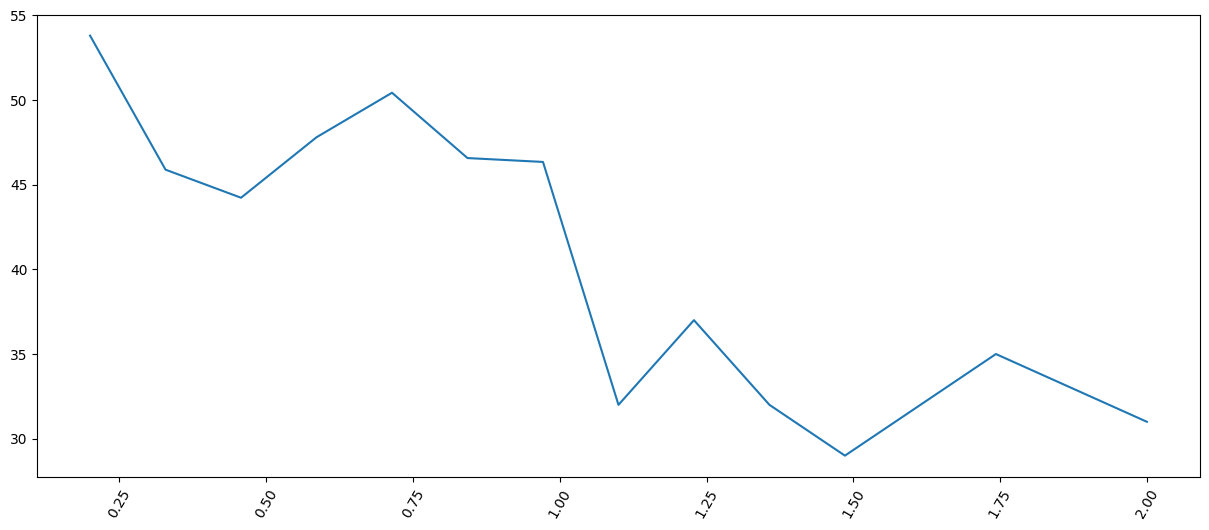

In [64]:
plt.figure(figsize=(15,6))
plt.xticks(rotation=60)
plt.plot(hi, energies_)

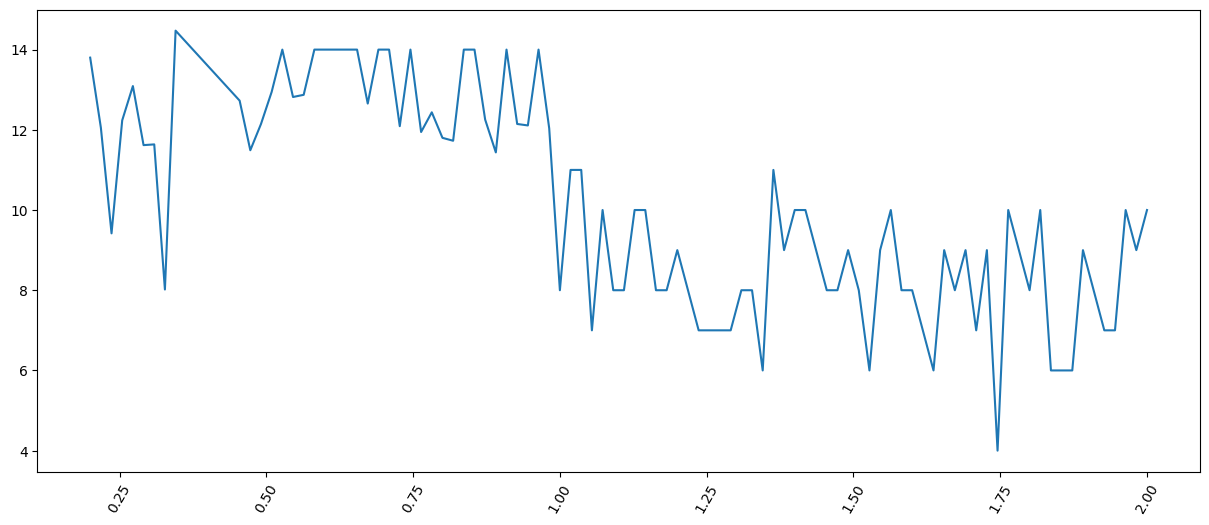

In [59]:
plt.figure(figsize=(15,6))
plt.xticks(rotation=60)
plt.plot(hi, energies_)


In [22]:
sub =  np.array([1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1])
energy(sub, W)

(-9, 13, -78, 67)

In [26]:
Ga = graph_from_dimacs("DIMACS_subset_ascii/C125.9.clq")


In [27]:
Ga.edges

EdgeView([(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 38), (1, 39), (1, 40), (1, 41), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 54), (1, 55), (1, 57), (1, 58), (1, 59), (1, 60), (1, 61), (1, 62), (1, 63), (1, 64), (1, 65), (1, 66), (1, 68), (1, 69), (1, 70), (1, 71), (1, 72), (1, 73), (1, 74), (1, 75), (1, 76), (1, 77), (1, 78), (1, 79), (1, 80), (1, 81), (1, 82), (1, 83), (1, 84), (1, 85), (1, 86), (1, 88), (1, 89), (1, 90), (1, 91), (1, 92), (1, 93), (1, 94), (1, 96), (1, 97), (1, 98), (1, 99), (1, 100), (1, 101), (1, 102), (1, 103), (1, 104), (1, 105), (1, 107), (1, 110), (1, 111), (1, 112), (1, 113), (1, 114), (1, 115), (1, 116), (1, 117), (1, 119), (1, 120), (1, 121), (1, 122)

In [28]:
for i in range(1,501):
    print(len(Ga.adj[i]))

112
113
107
112
112
113
117
117
113
114
116
108
112
109
106
106
108
115
117
111
109
114
111
115
113
111
111
110
116
113
112
110
108
114
112
102
111
109
115
116
113
106
111
112
118
113
115
113
116
108
105
113
111
119
109
110
112
112
114
119
110
111
109
106
114
111
116
108
112
115
110
112
105
113
104
104
114
109
112
117
108
114
102
111
113
113
110
106
109
105
112
114
110
106
106
113
106
116
117
108
117
109
108
118
109
111
111
103
112
117
118
109
106
119
112
108
112
112
113
110
111
111
114
110
116


KeyError: 126